In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, balanced_accuracy_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)
from utils import load_data, feature_selection, plot_graphs, preprocessing
from models import train

import dsatools
from dsatools import utilits as ut
from dsatools._base._imf_decomposition import emd
from imblearn.over_sampling import SMOTE, KMeansSMOTE
from catboost import CatBoostClassifier

#### Functions

In [2]:
def get_abs_values(df, column):
    df_values = pd.DataFrame()
    df_values["values"] = df[column].value_counts()
    df_values["%"] = df[column].value_counts(normalize=True)
    print(df_values)


def show_abs_values(df, column):
    df_values = pd.DataFrame()
    df_values["values"] = df[column].value_counts()
    df_values["%"] = df[column].value_counts(normalize=True) * 100
    return df_values.round(2)


def load_dataset(path, sheet):
    valid_classes = ['CBC', 'CEC', 'MEL', 'ACK', 'SEK', 'NEV', 'CEC/CBC']
    df = pd.read_excel(path, sheet_name=sheet) \
           .iloc[:, 5:-4]
    return df.loc[df['Classe'].isin(valid_classes)]


def plot_labels(df, column, figsize=(9, 6), title="cubic IMF 1"):
    fig = plt.figure(figsize=figsize)
    plt.title(title)
    for col in df[column].value_counts().index:
        df_sub = df.loc[df[column] == col]
        tidy = df_sub.iloc[:, 1:-2].stack().reset_index().rename(columns={"level_1": "comp_onda", 0: "absortion"})
        ax = sns.lineplot(data=tidy, x='comp_onda', y='absortion', label=col)


def plot_imf(X, method):
    signal = np.array(X)[0]
    imfs = emd(signal, order=2, method=method, max_itter=100)
    plt.plot(signal)
    ut.probe((imfs.sum(axis=0)))
    ut.probe((imfs[0]))
    ut.probe((imfs[1]))


def create_emd(X, method, degree):
    """
    create the IMFs for given signals
    """
    data_array = np.array(X)
    data_emd = []
    for signal in data_array:
        imfs = emd(signal, order=2, method=method, max_itter=100)
        data_emd.append(imfs[degree])
    return np.array(data_emd)


def create_emd_all(df, label):
    """
    create all the IMFs for signal degrees 1 and 2, on thin plate and cubic
    """
    methods = ['cubic', 'thin_plate']
    data_array = np.array(df)
    data_emd = []
    for signal in data_array:
        for m in methods:
            imfs = emd(signal, order=2, method=m, max_itter=100)
            data_emd.append(imfs[0])
            data_emd.append(imfs[1])
    df_emd = pd.DataFrame(data_emd, columns=df.columns)
    df_emd['label'] = label
    return df_emd


def fit_model_no_train_test(model, X_train, X_test, y_train, y_test, method):

    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print('ACCURACY:', round(accuracy_score(y_test, pred), 3))
    print('BALANCED ACCURACY', round(balanced_accuracy_score(y_test, pred), 3))
    print('F-SCORE:', round(f1_score(y_test, pred), 3))
    print('PRECISION:', round(precision_score(y_test, pred), 3))
    print('RECALL:', round(recall_score(y_test, pred), 3))
    print('AUC ROC:', round(roc_auc_score(y_test, pred), 3))

    df_metrics = pd.DataFrame(index=['ACCURACY', 'BALANCED ACCURACY', 
        'F-SCORE', 'PRECISION', 'RECALL', 'AUC ROC'], data={method: [round(accuracy_score(y_test, pred), 3), 
                                                                    round(balanced_accuracy_score(y_test, pred), 3),
                                                                    round(f1_score(y_test, pred), 3),
                                                                    round(precision_score(y_test, pred), 3),
                                                                    round(recall_score(y_test, pred), 3),
                                                                    round(roc_auc_score(y_test, pred), 3)]})
    return model, df_metrics

#### Analise específica - Nevo e Melanoma

In [36]:
# LOAD DATA TRAIN TEST

lista_accepted = ['NEV', 'MEL']

df_train = pd.read_excel('../data/Flavio.xlsx', sheet_name='Treinamento') \
    .set_index('Sample')

df_train = df_train \
    .loc[df_train['Classe'].isin(lista_accepted)] \
    .drop(['y'], axis=1)

X_train = df_train.drop(['Classe'], axis=1)
y_train = pd.get_dummies(df_train['Classe'], drop_first=True)#['maligno'].to_list()


df_test = pd.read_excel('../data/Flavio.xlsx', sheet_name='Teste') \
    .set_index('Sample')

df_test = df_test \
    .loc[df_test['Classe'].isin(lista_accepted)] \
    .drop(['y'], axis=1)

X_test = df_test.drop(['Classe'], axis=1)
y_test = pd.get_dummies(df_test['Classe'], drop_first=True)#['maligno'].to_list()

df_nev_mel = pd.concat([df_train, df_test])

X = df_nev_mel.drop(['Classe'], axis=1)
y = pd.get_dummies(df_nev_mel['Classe'], drop_first=True)['NEV'].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=1066, stratify=y)

print(len(X_train), len(X_test))

32 15


In [41]:
get_abs_values(df_train, 'Classe')

     values         %
NEV      32  0.941176
MEL       2  0.058824


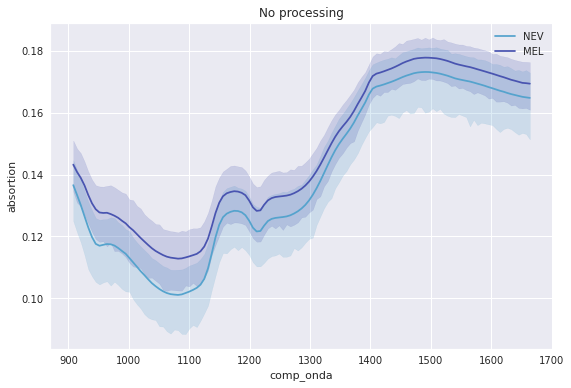

In [38]:
plot_labels(df_nev_mel, 'Classe', title="No processing")

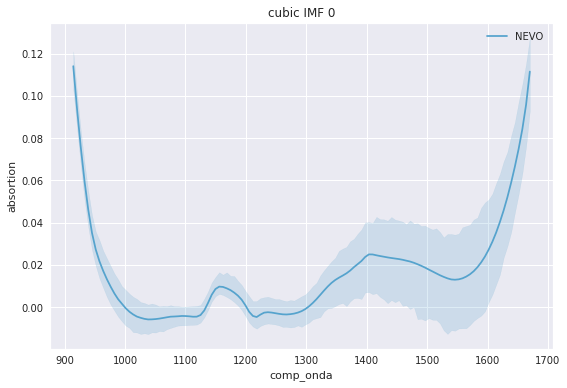

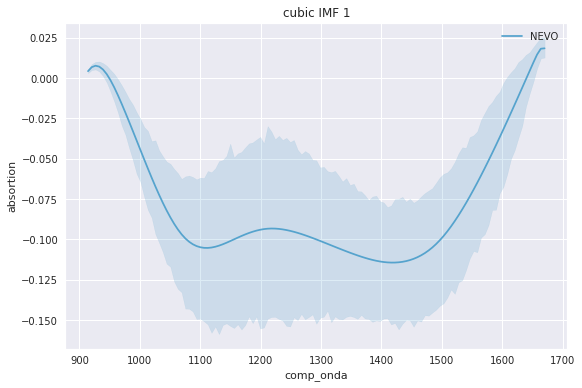

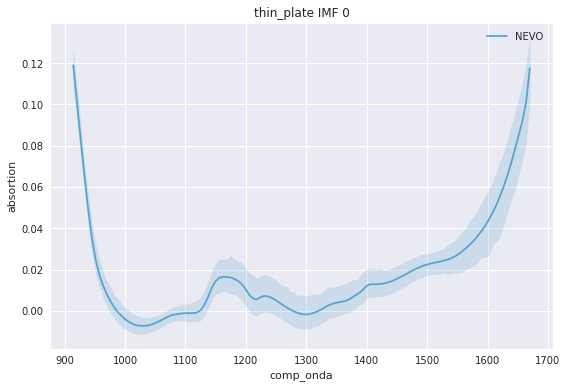

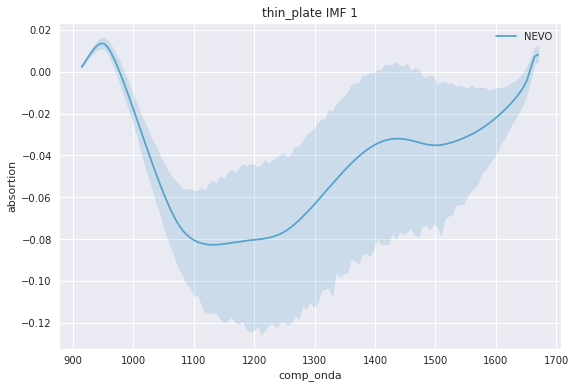

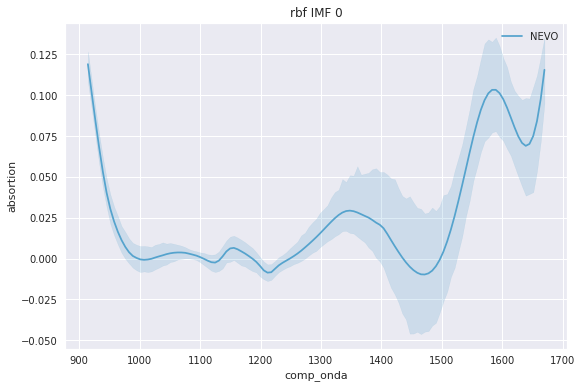

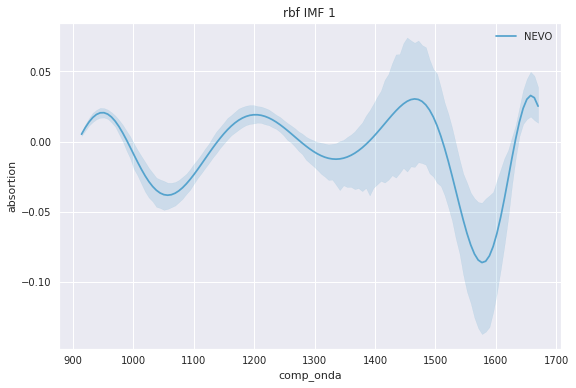

In [6]:
list_techniques = ['cubic', 'thin_plate', 'rbf']
list_degrees = [0, 1]
df_imf_nev = df_nev_mel.loc[df_nev_mel['Classe'] == 'NEV'].copy()
for technique in list_techniques:
    for degree in list_degrees:
        X_imf = pd.DataFrame(preprocessing.create_emd(df_imf_nev.drop(['Classe'], axis=1), method=technique, degree=degree), columns=X.columns)
        X_imf['Classe'] = 'NEVO'
        plot_labels(X_imf, 'Classe', title=f"{technique} IMF {degree}")

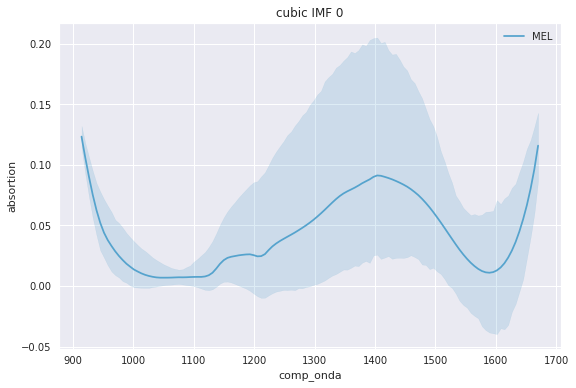

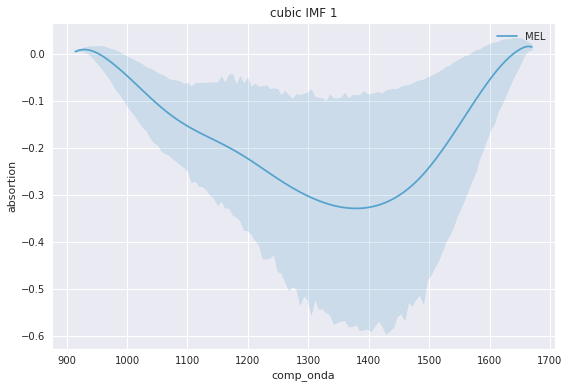

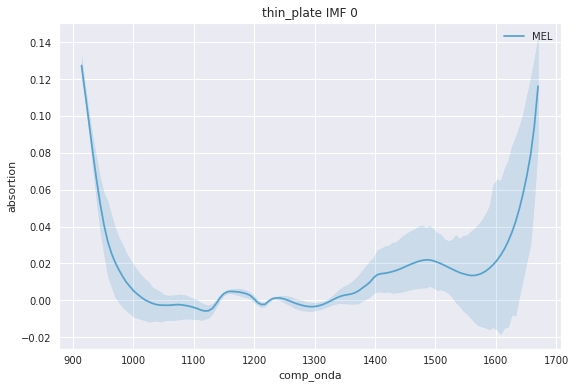

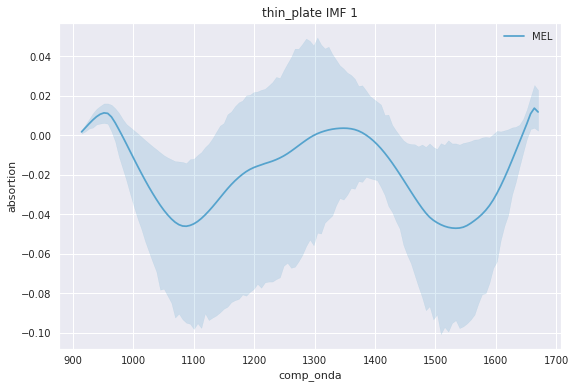

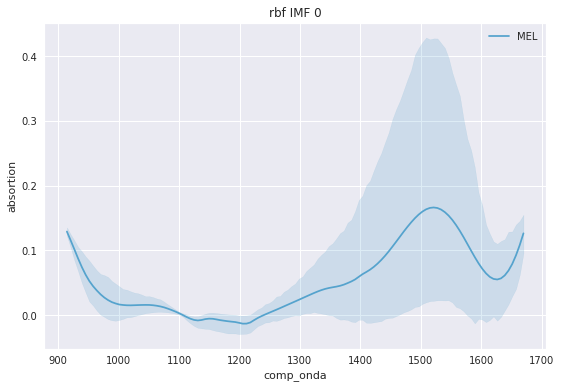

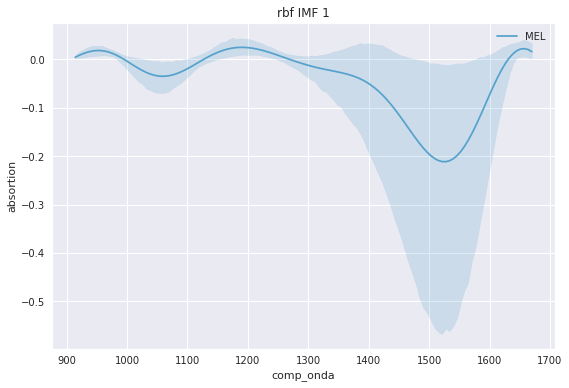

In [7]:
list_techniques = ['cubic', 'thin_plate', 'rbf']
list_degrees = [0, 1]
df_imf_nev = df_nev_mel.loc[df_nev_mel['Classe'] == 'MEL'].copy()
for technique in list_techniques:
    for degree in list_degrees:
        X_imf = pd.DataFrame(preprocessing.create_emd(df_imf_nev.drop(['Classe'], axis=1), method=technique, degree=degree), columns=X.columns)
        X_imf['Classe'] = 'MEL'
        plot_labels(X_imf, 'Classe', title=f"{technique} IMF {degree}")

#### SMOTE - Oversampling

In [39]:
# SMOTE

sm = SMOTE(random_state=1066, k_neighbors=3)

X_res, y_res = sm.fit_resample(X_train, y_train)

df_res = X_res.copy()
df_res['classe'] = y_res

show_abs_values(df_res, 'classe')

,values,%
1,28,50.0
0,28,50.0


#### IMF - NEV x MEL

In [87]:
mode = 'thin_plate'

# TRAIN
df_train_nev = df_res.loc[df_res['classe'] == 1]
X_nev = df_train_nev.drop(['classe'], axis=1)
X_nev_imf_0 = create_emd(X_nev, mode, 0)
X_nev_imf_1 = create_emd(X_nev, mode, 1)
X_train_nev = np.append(X_nev_imf_0, X_nev_imf_1, axis=0)
y_train_nev = np.array([1 for _ in range(len(X_train_nev))])

df_train_mel = df_res.loc[df_res['classe'] == 0]
X_mel = df_train_mel.drop(['classe'], axis=1)
X_mel_imf_0 = create_emd(X_mel, mode, 0)
X_mel_imf_1 = create_emd(X_mel, mode, 1)
X_train_mel = np.append(X_mel_imf_0, X_mel_imf_1, axis=0)
y_train_mel = np.array([0 for _ in range(len(X_train_mel))])

X_train_imf = np.append(X_train_nev, X_train_mel, axis=0)
y_train_imf = np.append(y_train_nev, y_train_mel, axis=0)


# TEST
df_test = X_test.copy()
df_test['classe'] = y_test

df_test_nev = df_test.loc[df_test['classe'] == 1]
X_nev = df_test_nev.drop(['classe'], axis=1)
X_nev_imf_0 = create_emd(X_nev, mode, 0)
X_nev_imf_1 = create_emd(X_nev, mode, 1)
X_test_nev = np.append(X_nev_imf_0, X_nev_imf_1, axis=0)
y_test_nev = np.array([1 for _ in range(len(X_test_nev))])

df_test_mel = df_test.loc[df_test['classe'] == 0]
X_mel = df_test_mel.drop(['classe'], axis=1)
X_mel_imf_0 = create_emd(X_mel, mode, 0)
X_mel_imf_1 = create_emd(X_mel, mode, 1)
X_test_mel = np.append(X_mel_imf_0, X_mel_imf_1, axis=0)
y_test_mel = np.array([0 for _ in range(len(X_test_mel))])

X_test_imf = np.append(X_test_nev, X_test_mel, axis=0)
y_test_imf = np.append(y_test_nev, y_test_mel, axis=0)

In [76]:
print(X_train_imf.shape, X_test_imf.shape, y_train_imf.shape, y_test_imf.shape)

(112, 125) (30, 125) (112,) (30,)


In [77]:
df_train_imf = pd.DataFrame(X_train_imf)
df_train_imf['nevo'] = y_train_imf
show_abs_values(df_train_imf, 'nevo')

,values,%
1,56,50.0
0,56,50.0


In [78]:
df_test_imf = pd.DataFrame(X_test_imf)
df_test_imf['nevo'] = y_test_imf
show_abs_values(df_test_imf, 'nevo')

,values,%
1,26,86.67
0,4,13.33


In [88]:
# SNV + Features
X_snv_train = pd.DataFrame(preprocessing.SNV(X_train_imf), columns=X_train.columns)
X_snv_test = pd.DataFrame(preprocessing.SNV(X_test_imf), columns=X_test.columns)

X_features_train = preprocessing.create_features(X_snv_train, n_subsets=26, mode='stats')
X_features_test = preprocessing.create_features(X_snv_test, n_subsets=26, mode='stats')

model = CatBoostClassifier(verbose=0, iterations=200)

model, df_metrics_nev_mel_features = fit_model_no_train_test(model, 
                                                    X_features_train, X_features_test, 
                                                    y_train_imf, y_test_imf,
                                                    method='NEV-MEL-FEATURES')

In [17]:
model = CatBoostClassifier(verbose=0, iterations=200)

model, df_metrics_nev_mel_thin_plate = fit_model_no_train_test(model, 
                                                    X_train_imf, X_test_imf, 
                                                    y_train_imf, y_test_imf,
                                                    method='NEV-MEL-THIN-PLATE')

ACCURACY: 0.867
BALANCED ACCURACY 0.712
F-SCORE: 0.923
PRECISION: 0.923
RECALL: 0.923
AUC ROC: 0.712


In [21]:
model = CatBoostClassifier(verbose=0, iterations=200)

model, df_metrics_nev_mel_cubic = fit_model_no_train_test(model, 
                                                    X_train_imf, X_test_imf, 
                                                    y_train_imf, y_test_imf,
                                                    method='NEV-MEL-CUBIC')

ACCURACY: 0.8
BALANCED ACCURACY 0.673
F-SCORE: 0.88
PRECISION: 0.917
RECALL: 0.846
AUC ROC: 0.673


In [24]:
model = CatBoostClassifier(verbose=0, iterations=200)

model, df_metrics_nev_mel_rbf = fit_model_no_train_test(model, 
                                                    X_train_imf, X_test_imf, 
                                                    y_train_imf, y_test_imf,
                                                    method='NEV-MEL-RBF')

ACCURACY: 0.833
BALANCED ACCURACY 0.481
F-SCORE: 0.909
PRECISION: 0.862
RECALL: 0.962
AUC ROC: 0.481


In [91]:
df_analysis = pd.concat([
    df_metrics_nev_mel_rbf,
    df_metrics_nev_mel_cubic,
    df_metrics_nev_mel_thin_plate,
    df_metrics_nev_mel_features
], axis=1)

display(df_analysis)

,NEV-MEL-RBF,NEV-MEL-CUBIC,NEV-MEL-THIN-PLATE,NEV-MEL-FEATURES
ACCURACY,0.833,0.800,0.867,0.833
BALANCED ACCURACY,0.481,0.673,0.712,0.692
F-SCORE,0.909,0.880,0.923,0.902
PRECISION,0.862,0.917,0.923,0.920
RECALL,0.962,0.846,0.923,0.885
AUC ROC,0.481,0.673,0.712,0.692


#### MEL x ACK

In [18]:
# LOAD DATA TRAIN TEST

lista_accepted = ['ACK', 'MEL']

df_train = pd.read_excel('../data/Flavio.xlsx', sheet_name='Treinamento') \
    .set_index('Sample')

df_train = df_train \
    .loc[df_train['Classe'].isin(lista_accepted)] \
    .drop(['y'], axis=1)

X_train = df_train.drop(['Classe'], axis=1)
y_train = pd.get_dummies(df_train['Classe'], drop_first=True)#['maligno'].to_list()


df_test = pd.read_excel('../data/Flavio.xlsx', sheet_name='Teste') \
    .set_index('Sample')

df_test = df_test \
    .loc[df_test['Classe'].isin(lista_accepted)] \
    .drop(['y'], axis=1)

X_test = df_test.drop(['Classe'], axis=1)
y_test = pd.get_dummies(df_test['Classe'], drop_first=True)#['maligno'].to_list()

df_ack_mel = pd.concat([df_train, df_test])

X = df_ack_mel.drop(['Classe'], axis=1)
y = pd.get_dummies(df_ack_mel['Classe'], drop_first=True)#['ACK'].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=1066, stratify=y)

print(len(X_train), len(X_test))

211 91


In [19]:
get_abs_values(df_ack_mel, 'Classe')

     values         %
ACK     296  0.980132
MEL       6  0.019868


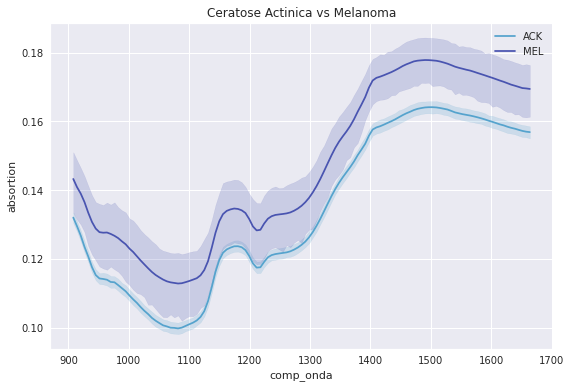

In [20]:
plot_labels(df_ack_mel, 'Classe', title="Ceratose Actinica vs Melanoma")

In [21]:
df_imbalance = X_train.copy()
df_imbalance['classe'] = y_train

show_abs_values(df_imbalance, 'classe')

,values,%
0,207,98.1
1,4,1.9


In [22]:
# SMOTE

sm = SMOTE(random_state=1066, k_neighbors=3)

X_res, y_res = sm.fit_resample(X_train, y_train)

df_res = X_res.copy()
df_res['classe'] = y_res

show_abs_values(df_res, 'classe')

,values,%
0,207,50.0
1,207,50.0


In [23]:
mode = 'thin_plate'

# TRAIN
df_train_ack = df_res.loc[df_res['classe'] == 0]
X_ack = df_train_ack.drop(['classe'], axis=1)
X_ack_imf_0 = create_emd(X_ack, mode, 0)
X_ack_imf_1 = create_emd(X_ack, mode, 1)
X_train_ack = np.append(X_ack_imf_0, X_ack_imf_1, axis=0)
y_train_ack = np.array([0 for _ in range(len(X_train_ack))])

df_train_mel = df_res.loc[df_res['classe'] == 1]
X_mel = df_train_mel.drop(['classe'], axis=1)
X_mel_imf_0 = create_emd(X_mel, mode, 0)
X_mel_imf_1 = create_emd(X_mel, mode, 1)
X_train_mel = np.append(X_mel_imf_0, X_mel_imf_1, axis=0)
y_train_mel = np.array([1 for _ in range(len(X_train_mel))])

X_train_imf = np.append(X_train_ack, X_train_mel, axis=0)
y_train_imf = np.append(y_train_ack, y_train_mel, axis=0)


# TEST
df_test = X_test.copy()
df_test['classe'] = y_test

df_test_ack = df_test.loc[df_test['classe'] == 0]
X_ack = df_test_ack.drop(['classe'], axis=1)
X_ack_imf_0 = create_emd(X_ack, mode, 0)
X_ack_imf_1 = create_emd(X_ack, mode, 1)
X_test_ack = np.append(X_ack_imf_0, X_ack_imf_1, axis=0)
y_test_ack = np.array([0 for _ in range(len(X_test_ack))])

df_test_mel = df_test.loc[df_test['classe'] == 1]
X_mel = df_test_mel.drop(['classe'], axis=1)
X_mel_imf_0 = create_emd(X_mel, mode, 0)
X_mel_imf_1 = create_emd(X_mel, mode, 1)
X_test_mel = np.append(X_mel_imf_0, X_mel_imf_1, axis=0)
y_test_mel = np.array([1 for _ in range(len(X_test_mel))])

X_test_imf = np.append(X_test_ack, X_test_mel, axis=0)
y_test_imf = np.append(y_test_ack, y_test_mel, axis=0)

In [24]:
print(len(X_train_imf), len(X_test_imf), len(y_train_imf), len(y_test_imf))

828 182 828 182


In [25]:
# SNV + Features
X_snv_train = pd.DataFrame(preprocessing.SNV(X_train_imf), columns=X_train.columns)
X_snv_test = pd.DataFrame(preprocessing.SNV(X_test_imf), columns=X_test.columns)

X_features_train = preprocessing.create_features(X_snv_train, n_subsets=26, mode='stats')
X_features_test = preprocessing.create_features(X_snv_test, n_subsets=26, mode='stats')

model = CatBoostClassifier(verbose=0, iterations=200)

model, df_metrics_ack_mel_features = fit_model_no_train_test(model, 
                                                    X_features_train, X_features_test, 
                                                    y_train_imf, y_test_imf,
                                                    method='ACK-MEL-FEATURES')

ACCURACY: 0.929
BALANCED ACCURACY 0.597
F-SCORE: 0.133
PRECISION: 0.091
RECALL: 0.25
AUC ROC: 0.597


In [26]:
model = CatBoostClassifier(verbose=0, iterations=200)

model, df_metrics_ack_mel_thin_plate = fit_model_no_train_test(model, 
                                                    X_train_imf, X_test_imf, 
                                                    y_train_imf, y_test_imf,
                                                    method='ACK-MEL-THIN-PLATE')

ACCURACY: 0.901
BALANCED ACCURACY 0.461
F-SCORE: 0.0
PRECISION: 0.0
RECALL: 0.0
AUC ROC: 0.461


#### SEK x MEL

In [27]:
# LOAD DATA TRAIN TEST

lista_accepted = ['SEK', 'MEL']

df_train = pd.read_excel('../data/Flavio.xlsx', sheet_name='Treinamento') \
    .set_index('Sample')

df_train = df_train \
    .loc[df_train['Classe'].isin(lista_accepted)] \
    .drop(['y'], axis=1)

X_train = df_train.drop(['Classe'], axis=1)
y_train = pd.get_dummies(df_train['Classe'], drop_first=True)#['maligno'].to_list()


df_test = pd.read_excel('../data/Flavio.xlsx', sheet_name='Teste') \
    .set_index('Sample')

df_test = df_test \
    .loc[df_test['Classe'].isin(lista_accepted)] \
    .drop(['y'], axis=1)

X_test = df_test.drop(['Classe'], axis=1)
y_test = pd.get_dummies(df_test['Classe'], drop_first=True)#['maligno'].to_list()

df_sek_mel = pd.concat([df_train, df_test])

X = df_sek_mel.drop(['Classe'], axis=1)
y = pd.get_dummies(df_sek_mel['Classe'], drop_first=True)#['ACK'].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=1066, stratify=y)

print(len(X_train), len(X_test))

79 34


In [28]:
get_abs_values(df_sek_mel, 'Classe')

     values         %
SEK     107  0.946903
MEL       6  0.053097


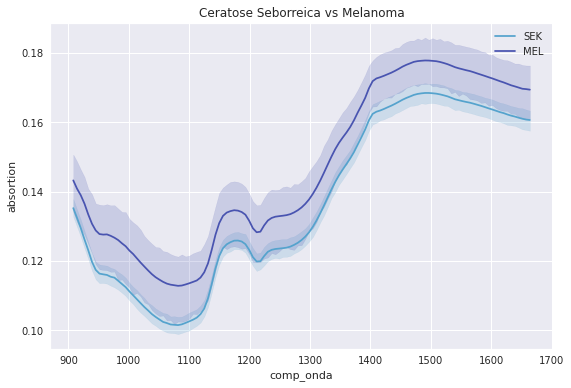

In [29]:
plot_labels(df_sek_mel, 'Classe', title="Ceratose Seborreica vs Melanoma")

In [30]:
df_imbalance = X_train.copy()
df_imbalance['classe'] = y_train

show_abs_values(df_imbalance, 'classe')

,values,%
1,75,94.94
0,4,5.06


In [31]:
# SMOTE

sm = SMOTE(random_state=1066, k_neighbors=3)

X_res, y_res = sm.fit_resample(X_train, y_train)

df_res = X_res.copy()
df_res['classe'] = y_res

show_abs_values(df_res, 'classe')

,values,%
1,75,50.0
0,75,50.0


In [32]:
mode = 'thin_plate'

# TRAIN
df_train_sek = df_res.loc[df_res['classe'] == 0]
X_sek = df_train_sek.drop(['classe'], axis=1)
X_sek_imf_0 = create_emd(X_sek, mode, 0)
X_sek_imf_1 = create_emd(X_sek, mode, 1)
X_train_sek = np.append(X_sek_imf_0, X_sek_imf_1, axis=0)
y_train_sek = np.array([0 for _ in range(len(X_train_sek))])

df_train_mel = df_res.loc[df_res['classe'] == 1]
X_mel = df_train_mel.drop(['classe'], axis=1)
X_mel_imf_0 = create_emd(X_mel, mode, 0)
X_mel_imf_1 = create_emd(X_mel, mode, 1)
X_train_mel = np.append(X_mel_imf_0, X_mel_imf_1, axis=0)
y_train_mel = np.array([1 for _ in range(len(X_train_mel))])

X_train_imf = np.append(X_train_sek, X_train_mel, axis=0)
y_train_imf = np.append(y_train_sek, y_train_mel, axis=0)


# TEST
df_test = X_test.copy()
df_test['classe'] = y_test

df_test_sek = df_test.loc[df_test['classe'] == 0]
X_sek = df_test_sek.drop(['classe'], axis=1)
X_sek_imf_0 = create_emd(X_sek, mode, 0)
X_sek_imf_1 = create_emd(X_sek, mode, 1)
X_test_sek = np.append(X_sek_imf_0, X_sek_imf_1, axis=0)
y_test_sek = np.array([0 for _ in range(len(X_test_sek))])

df_test_mel = df_test.loc[df_test['classe'] == 1]
X_mel = df_test_mel.drop(['classe'], axis=1)
X_mel_imf_0 = create_emd(X_mel, mode, 0)
X_mel_imf_1 = create_emd(X_mel, mode, 1)
X_test_mel = np.append(X_mel_imf_0, X_mel_imf_1, axis=0)
y_test_mel = np.array([1 for _ in range(len(X_test_mel))])

X_test_imf = np.append(X_test_sek, X_test_mel, axis=0)
y_test_imf = np.append(y_test_sek, y_test_mel, axis=0)

In [35]:
print(len(X_train_imf), len(X_test_imf), len(y_train_imf), len(y_test_imf))

300 68 300 68


In [33]:
# SNV + Features
X_snv_train = pd.DataFrame(preprocessing.SNV(X_train_imf), columns=X_train.columns)
X_snv_test = pd.DataFrame(preprocessing.SNV(X_test_imf), columns=X_test.columns)

X_features_train = preprocessing.create_features(X_snv_train, n_subsets=26, mode='stats')
X_features_test = preprocessing.create_features(X_snv_test, n_subsets=26, mode='stats')

model = CatBoostClassifier(verbose=0, iterations=200)

model, df_metrics_sek_mel_features = fit_model_no_train_test(model, 
                                                    X_features_train, X_features_test, 
                                                    y_train_imf, y_test_imf,
                                                    method='SEK-MEL-FEATURES')

ACCURACY: 0.941
BALANCED ACCURACY 0.617
F-SCORE: 0.969
PRECISION: 0.955
RECALL: 0.984
AUC ROC: 0.617


In [34]:
model = CatBoostClassifier(verbose=0, iterations=200)

model, df_metrics_sek_mel_thin_plate = fit_model_no_train_test(model, 
                                                    X_train_imf, X_test_imf, 
                                                    y_train_imf, y_test_imf,
                                                    method='SEK-MEL-THIN-PLATE')

ACCURACY: 0.897
BALANCED ACCURACY 0.594
F-SCORE: 0.945
PRECISION: 0.952
RECALL: 0.938
AUC ROC: 0.594


#### All IMFs

In [93]:
mode_rbf = 'rbf'
mode_thin_plate = 'thin_plate'
mode_cubic = 'cubic'

# TRAIN
df_train_nev = df_res.loc[df_res['classe'] == 1]
X_nev = df_train_nev.drop(['classe'], axis=1)

X_nev_imf_0 = create_emd(X_nev, mode_rbf, 0)
X_nev_imf_1 = create_emd(X_nev, mode_rbf, 1)
X_nev_imf_2 = create_emd(X_nev, mode_thin_plate, 0)
X_nev_imf_3 = create_emd(X_nev, mode_thin_plate, 1)
X_nev_imf_4 = create_emd(X_nev, mode_cubic, 0)
X_nev_imf_5 = create_emd(X_nev, mode_cubic, 1)

X_train_nev = np.append(
    [X_nev_imf_0], [X_nev_imf_1,
    X_nev_imf_2, X_nev_imf_3,
    X_nev_imf_4, X_nev_imf_5,
], axis=0).reshape(168, 125)
y_train_nev = np.array([1 for _ in range(len(X_train_nev))])

df_train_mel = df_res.loc[df_res['classe'] == 0]
X_mel = df_train_mel.drop(['classe'], axis=1)

X_mel_imf_0 = create_emd(X_mel, mode_rbf, 0)
X_mel_imf_1 = create_emd(X_mel, mode_rbf, 1)
X_mel_imf_2 = create_emd(X_mel, mode_thin_plate, 0)
X_mel_imf_3 = create_emd(X_mel, mode_thin_plate, 1)
X_mel_imf_4 = create_emd(X_mel, mode_cubic, 0)
X_mel_imf_5 = create_emd(X_mel, mode_cubic, 1)

X_train_mel = np.append(
    [X_mel_imf_0], [X_mel_imf_1,
    X_mel_imf_2, X_mel_imf_3,
    X_mel_imf_4, X_mel_imf_5
], axis=0).reshape(168, 125)
y_train_mel = np.array([0 for _ in range(len(X_train_mel))])

X_train_imf = np.append(X_train_nev, X_train_mel, axis=0)
y_train_imf = np.append(y_train_nev, y_train_mel, axis=0)


# TEST
df_test = X_test.copy()
df_test['classe'] = y_test

df_test_nev = df_test.loc[df_test['classe'] == 1]
X_nev = df_test_nev.drop(['classe'], axis=1)

X_nev_imf_0 = create_emd(X_nev, mode_rbf, 0)
X_nev_imf_1 = create_emd(X_nev, mode_rbf, 1)
X_nev_imf_2 = create_emd(X_nev, mode_thin_plate, 0)
X_nev_imf_3 = create_emd(X_nev, mode_thin_plate, 1)
X_nev_imf_4 = create_emd(X_nev, mode_cubic, 0)
X_nev_imf_5 = create_emd(X_nev, mode_cubic, 1)

X_test_nev = np.append(
    [X_nev_imf_0], [X_nev_imf_1,
    X_nev_imf_2, X_nev_imf_3,
    X_nev_imf_4, X_nev_imf_5
], axis=0).reshape(78, 125)
y_test_nev = np.array([1 for _ in range(len(X_test_nev))])

df_test_mel = df_test.loc[df_test['classe'] == 0]
X_mel = df_test_mel.drop(['classe'], axis=1)

X_mel_imf_0 = create_emd(X_mel, mode_rbf, 0)
X_mel_imf_1 = create_emd(X_mel, mode_rbf, 1)
X_mel_imf_2 = create_emd(X_mel, mode_thin_plate, 0)
X_mel_imf_3 = create_emd(X_mel, mode_thin_plate, 1)
X_mel_imf_4 = create_emd(X_mel, mode_cubic, 0)
X_mel_imf_5 = create_emd(X_mel, mode_cubic, 1)

X_test_mel = np.append(
    [X_mel_imf_0],
    [X_mel_imf_1, X_mel_imf_2, 
    X_mel_imf_3, X_mel_imf_4, 
    X_mel_imf_5], 
    axis=0).reshape(12, 125)
y_test_mel = np.array([0 for _ in range(len(X_test_mel))])

X_test_imf = np.append(X_test_nev, X_test_mel, axis=0)
y_test_imf = np.append(y_test_nev, y_test_mel, axis=0)

In [60]:
print(X_train_imf.shape, X_test_imf.shape, y_train_imf.shape, y_test_imf.shape)

(336, 125) (90, 125) (336,) (90,)


In [61]:
model = CatBoostClassifier(verbose=0, iterations=200)

model, df_metrics_nev_mel_all = fit_model_no_train_test(model, 
                                                    X_train_imf, X_test_imf, 
                                                    y_train_imf, y_test_imf,
                                                    method='NEV-MEL-ALL')

ACCURACY: 0.656
BALANCED ACCURACY 0.449
F-SCORE: 0.786
PRECISION: 0.851
RECALL: 0.731
AUC ROC: 0.449


#### Analise IMF

          values         %
nevo         288  0.923077
melanoma      24  0.076923


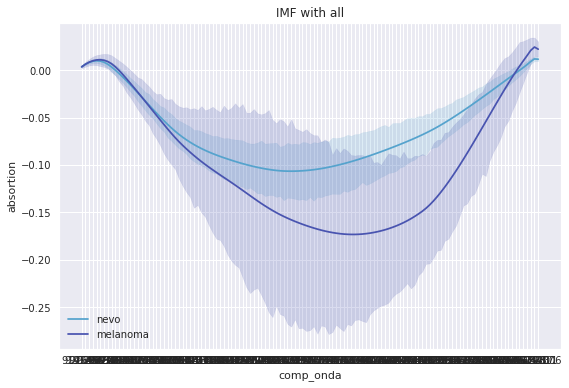

In [ ]:
X_mel = df.loc[df['resultado'] == 'melanoma'].iloc[:, 1:-2]
imf_mel = create_emd_all(X_mel, label='melanoma')

X_nevo = df.loc[df['resultado'] == 'nevo'].iloc[:, 1:-2]
imf_nevo = create_emd_all(X_nevo, label='nevo')

df_imf = pd.concat([imf_mel, imf_nevo])
get_abs_values(df_imf, 'label')
plot_labels(df_imf, 'label', title="IMF with all")

          values     %
nevo          72  0.75
melanoma      24  0.25


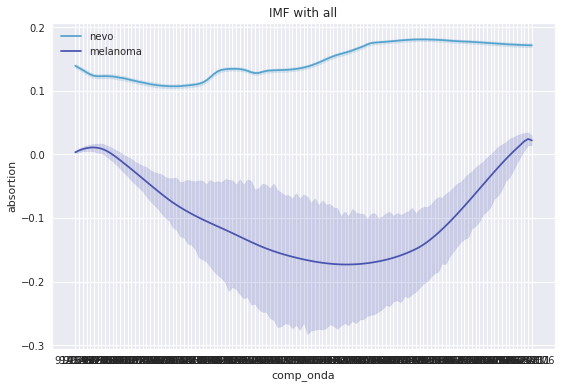

In [ ]:
X_mel = df.loc[df['resultado'] == 'melanoma'].iloc[:, 1:-2]
imf_mel = create_emd_all(X_mel, label='melanoma')

imf_nevo = df.loc[df['resultado'] == 'nevo'].drop(['resultado', 'index_sus'], axis=1)
imf_nevo['label'] = 'nevo'

df_imf = pd.concat([imf_mel, imf_nevo]).reset_index(drop=True)
get_abs_values(df_imf, 'label')
plot_labels(df_imf, 'label', title="IMF with all")

In [7]:
df = pd.read_csv("../../data/data_complete.csv", index_col=0)
# df = pd.read_csv("../../data/data_complete_mean.csv", index_col=0)
df = df.loc[(df.resultado == 'melanoma') | (df.resultado == 'nevo') | (df.resultado == 'ceratose seborreica')].reset_index(drop=True)
get_abs_values(df, 'resultado')
get_abs_values(df, 'label')

                     values         %
ceratose seborreica     225  0.742574
nevo                     72  0.237624
melanoma                  6  0.019802
         values         %
benigno     297  0.980198
maligno       6  0.019802


In [13]:
# Pre-processamento
X = df.iloc[:, 1:-2]
y = pd.get_dummies(df.resultado, drop_first=True).values
y_label = df.resultado

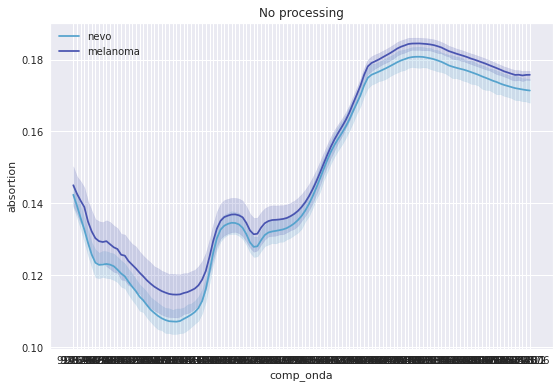

In [17]:
plot_labels(df, 'resultado', title="No processing")

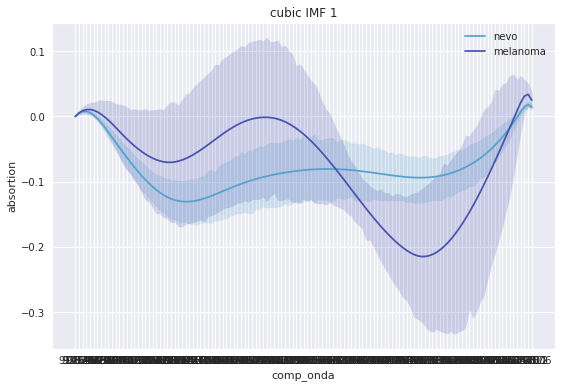

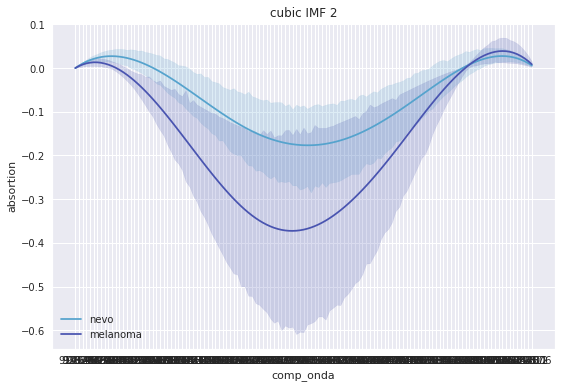

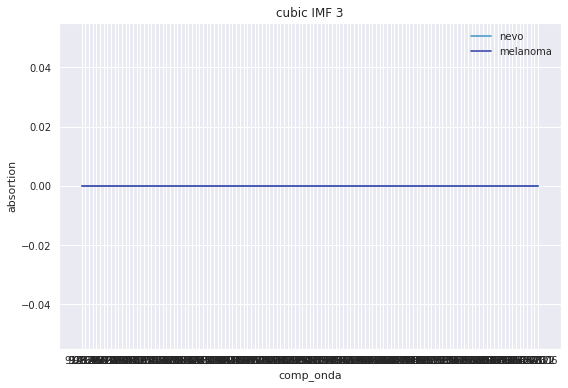

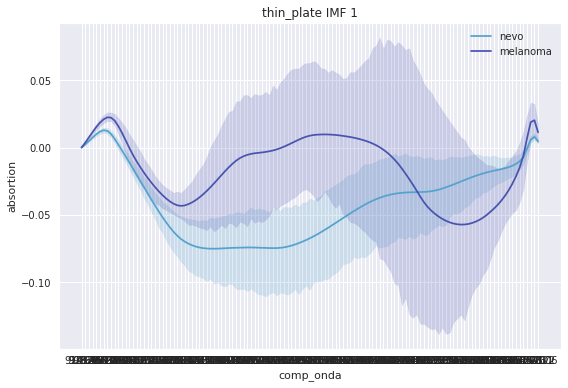

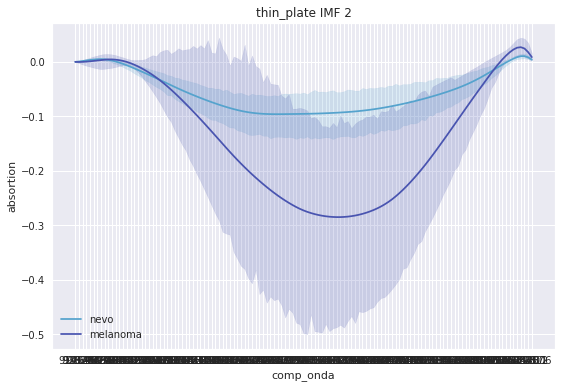

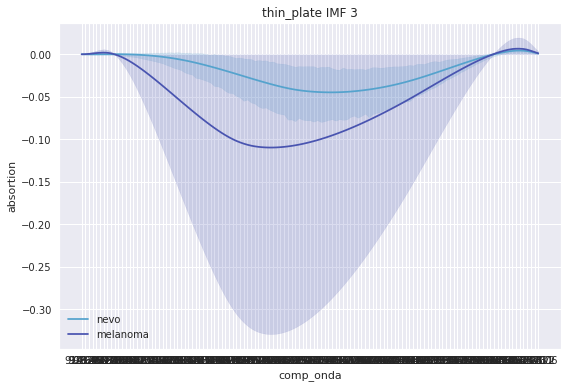

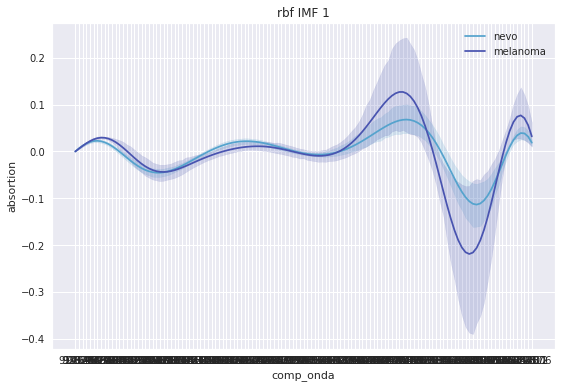

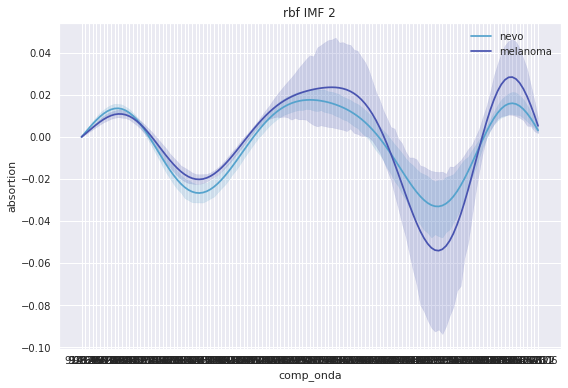

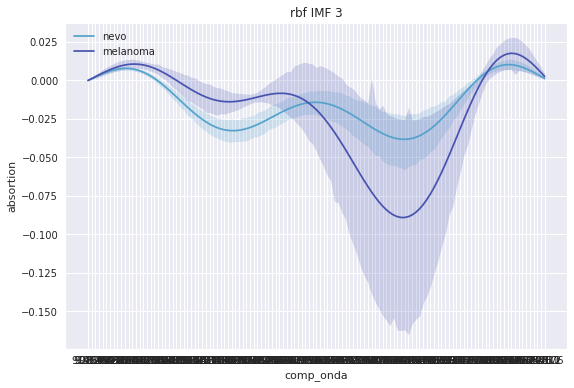

In [18]:
list_techniques = ['cubic', 'thin_plate', 'rbf']
list_degrees = [1, 2, 3]
df_imf = df.copy()
for technique in list_techniques:
    for degree in list_degrees:
        X_imf = pd.DataFrame(preprocessing.create_emd(X, method=technique, degree=degree), columns=X.columns)
        df_imf.iloc[:, 1:-2] = X_imf
        plot_labels(df_imf, 'resultado', title=f"{technique} IMF {degree}")

          values         %
nevo         288  0.923077
melanoma      24  0.076923


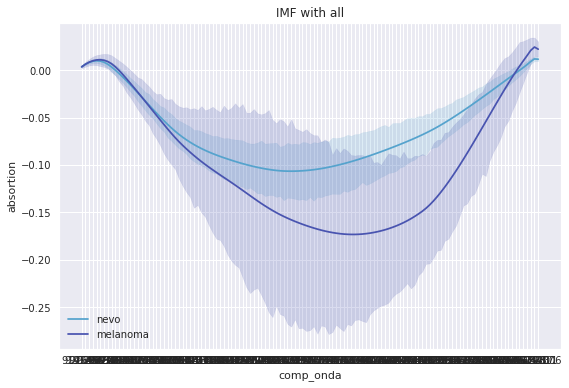

In [19]:
X_mel = df.loc[df['resultado'] == 'melanoma'].iloc[:, 1:-2]
imf_mel = create_emd_all(X_mel, label='melanoma')

X_nevo = df.loc[df['resultado'] == 'nevo'].iloc[:, 1:-2]
imf_nevo = create_emd_all(X_nevo, label='nevo')

df_imf = pd.concat([imf_mel, imf_nevo])
get_abs_values(df_imf, 'label')
plot_labels(df_imf, 'label', title="IMF with all")

          values     %
nevo          72  0.75
melanoma      24  0.25


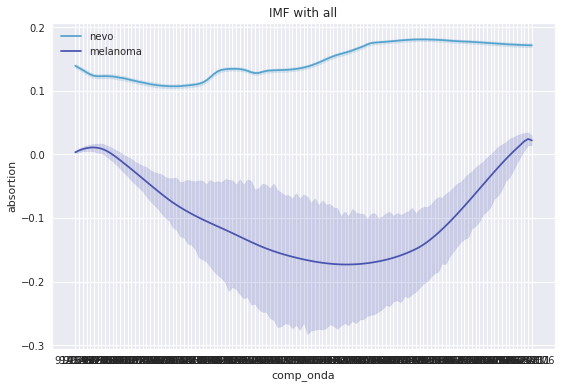

In [20]:
X_mel = df.loc[df['resultado'] == 'melanoma'].iloc[:, 1:-2]
imf_mel = create_emd_all(X_mel, label='melanoma')

imf_nevo = df.loc[df['resultado'] == 'nevo'].drop(['resultado', 'index_sus'], axis=1)
imf_nevo['label'] = 'nevo'

df_imf = pd.concat([imf_mel, imf_nevo]).reset_index(drop=True)
get_abs_values(df_imf, 'label')
plot_labels(df_imf, 'label', title="IMF with all")

#### Hilbert-Huang Transform

In [6]:
np.array(X)[1]
print(len(np.array(X)[1]))

125


<AxesSubplot:xlabel='Time (samples)'>

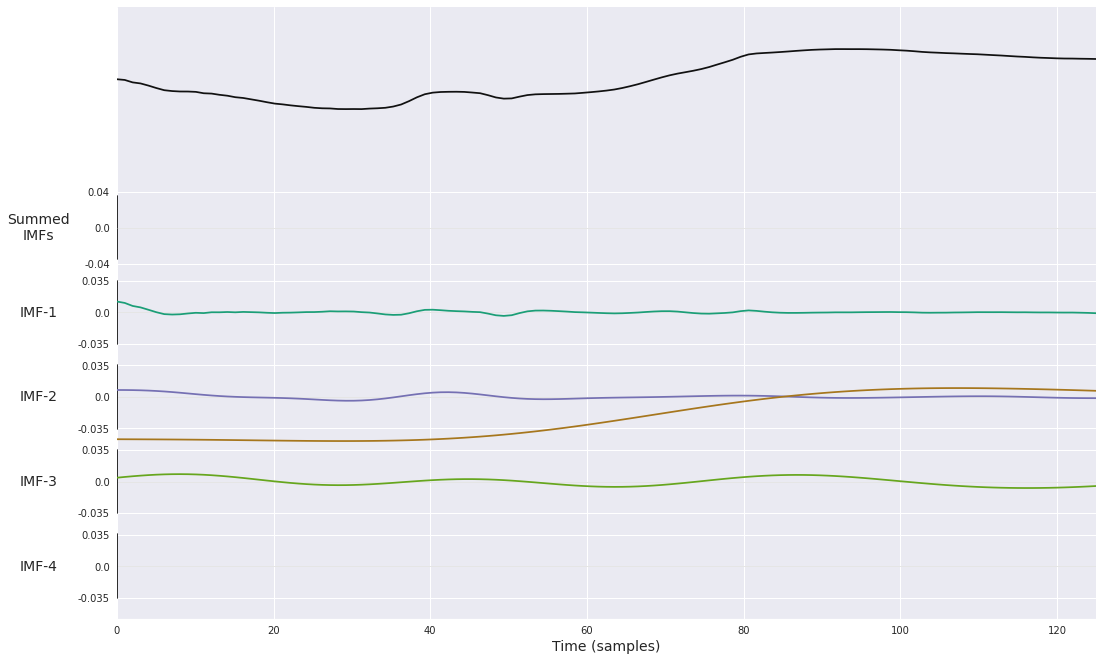

In [7]:
peak_freq = 15
sample_rate = 256
seconds = 10
noise_std = .4

imf = emd.sift.mask_sift(np.array(X)[1], max_imfs=5)
emd.plotting.plot_imfs(imf[:sample_rate*3, :])

In [8]:
# Compute frequency statistics
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')

Text(0.5, 0, 'Frequency (Hz)')

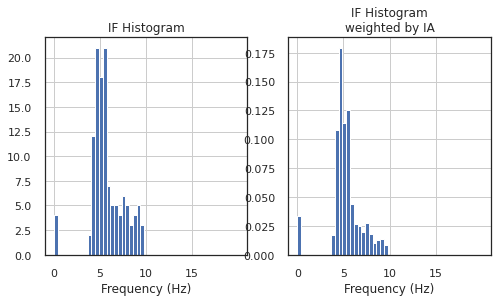

In [28]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
# Plot a simple histogram using frequency bins from 0-20Hz
plt.hist(IF[:, 2], np.linspace(0, 20))
plt.grid(True)
plt.title('IF Histogram')
plt.xticks(np.arange(0, 20, 5))
plt.xlabel('Frequency (Hz)')

plt.subplot(122)
# Plot an amplitude-weighted histogram using frequency bins from 0-20Hz
plt.hist(IF[:, 2], np.linspace(0, 20), weights=IA[:, 2])
plt.grid(True)
plt.title('IF Histogram\nweighted by IA')
plt.xticks(np.arange(0, 20, 5))
plt.xlabel('Frequency (Hz)')

In [9]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 50, 8, 'log')

# We round the values to 3dp for easier visualisation
print('Bin Edges:   {0}'.format(np.round(freq_edges, 3)))
print('Bin Centres: {0}'.format(np.round(freq_centres, 3)))

Bin Edges:   [ 1.     1.631  2.659  4.336  7.071 11.531 18.803 30.662 50.   ]
Bin Centres: [ 1.315  2.145  3.498  5.704  9.301 15.167 24.732 40.331]


In [10]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(0, 100, 128, 'linear')

# Amplitude weighted HHT per IMF
f, spec_weighted = emd.spectra.hilberthuang(IF, IA, freq_edges, sum_imfs=False)

125


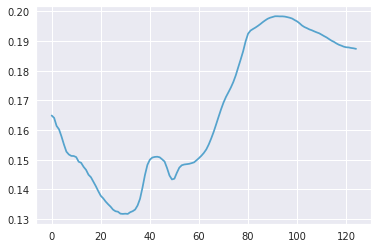

In [11]:
print(len(np.array(X)[1]))
plt.plot(np.array(X)[1])

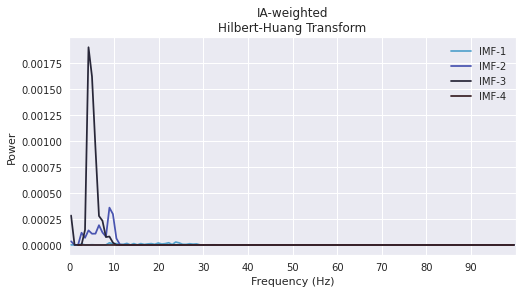

In [12]:
# plt.subplot(122)
plt.figure(figsize=(8, 4))
plt.plot(freq_centres, spec_weighted)
plt.xticks(np.arange(10)*10)
plt.xlim(0, 100)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('IA-weighted\nHilbert-Huang Transform')
plt.legend(['IMF-1', 'IMF-2', 'IMF-3', 'IMF-4', 'IMF-5'], frameon=False)